In [31]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [3]:
exchange_data = pd.read_csv('forex_data_10y.csv')
exchange_data.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,25-Aug-20,74.327,74.100,74.335,74.075,0.92K,0.22%
1,24-Aug-20,74.168,74.922,74.922,73.962,4.90K,-1.01%
2,23-Aug-20,74.922,74.922,74.922,74.922,0,0.00%
3,21-Aug-20,74.920,74.980,75.005,74.820,3.16K,-0.12%
4,20-Aug-20,75.012,74.973,75.132,74.935,3.70K,0.22%


In [4]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [5]:
ind_exchange_data.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2020-08-25,74.327,74.100,74.335,74.075,0.92K,0.22%
2020-08-24,74.168,74.922,74.922,73.962,4.90K,-1.01%
2020-08-23,74.922,74.922,74.922,74.922,0,0.00%
2020-08-21,74.920,74.980,75.005,74.820,3.16K,-0.12%
2020-08-20,75.012,74.973,75.132,74.935,3.70K,0.22%


In [6]:
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Chg%,High,Low,Open,Price,Volume
Date,,,,,,
2010-09-13,0.05%,46.415,46.100,46.220,46.310,0
2010-09-14,-0.09%,46.465,46.070,46.270,46.270,0
2010-09-15,-0.15%,46.460,46.080,46.160,46.200,0
2010-09-16,-0.12%,46.415,46.075,46.145,46.145,0
2010-09-17,-0.63%,46.128,45.785,46.085,45.855,0


In [7]:
cols = list(data_frame)[1:5]
print(cols)

['High', 'Low', 'Open', 'Price']


In [8]:
df = data_frame[cols].astype(float)
print(df)

              High     Low    Open   Price
Date                                      
2010-09-13  46.415  46.100  46.220  46.310
2010-09-14  46.465  46.070  46.270  46.270
2010-09-15  46.460  46.080  46.160  46.200
2010-09-16  46.415  46.075  46.145  46.145
2010-09-17  46.128  45.785  46.085  45.855
...            ...     ...     ...     ...
2020-08-20  75.132  74.935  74.973  75.012
2020-08-21  75.005  74.820  74.980  74.920
2020-08-23  74.922  74.922  74.922  74.922
2020-08-24  74.922  73.962  74.922  74.168
2020-08-25  74.335  74.075  74.100  74.327

[2598 rows x 4 columns]


In [9]:

df['SMA-200'] = df.Price.rolling(200).mean()
df['SMA-100'] = df.Price.rolling(100).mean() 
df['SMA-50'] = df.Price.rolling(50).mean() 
df['SMA-28'] = df.Price.rolling(28).mean() 
df['SMA-14'] = df.Price.rolling(14).mean() 








In [10]:
df['EMA-200'] = df['Price'].ewm(span=200, adjust=False, min_periods = 200).mean()
df['EMA-100'] = df['Price'].ewm(span=100, adjust=False,min_periods = 100).mean()
df['EMA-50'] = df['Price'].ewm(span=50, adjust=False, min_periods = 50).mean()
df['EMA-28'] = df['Price'].ewm(span=28, adjust=False, min_periods = 28).mean()
df['EMA-14'] = df['Price'].ewm(span=14, adjust=False, min_periods = 200).mean()

In [11]:
df.head()

,High,Low,Open,Price,SMA-200,SMA-100,SMA-50,SMA-28,SMA-14,EMA-200,EMA-100,EMA-50,EMA-28,EMA-14
Date,,,,,,,,,,,,,,
2010-09-13,46.415,46.100,46.220,46.310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-14,46.465,46.070,46.270,46.270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-15,46.460,46.080,46.160,46.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-16,46.415,46.075,46.145,46.145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-17,46.128,45.785,46.085,45.855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df = df.dropna()



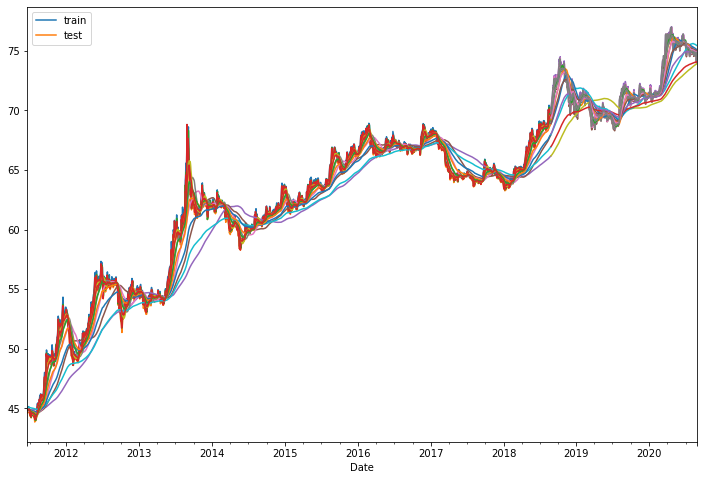

In [45]:
split_date = pd.Timestamp('26-08-2018')
train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

In [46]:
sc = MinMaxScaler(feature_range = (0,1))
train_sc = sc.fit_transform(train)
test_sc = sc.fit_transform(test)

X_train = train_sc[:, :]
X_test = test_sc[:,:]


Y_train = train_sc[:, 3]
Y_test = test_sc[:, 3]

print(X_train)
print(Y_train)







[[0.03295074 0.0344959  0.03203661 ... 0.01132961 0.01642456 0.02115414]
 [0.03637124 0.02954069 0.02784134 ... 0.0116242  0.01688662 0.02203799]
 [0.03295074 0.03525824 0.03432494 ... 0.01165713 0.01688691 0.02198925]
 ...
 [0.98004713 0.98894606 0.98665141 ... 0.99592111 0.99539882 0.99514529]
 [0.99049863 0.99534972 0.99180015 ... 0.99811244 0.99797548 0.99812618]
 [0.99315901 0.99268153 0.99961861 ... 1.         1.         1.        ]]
[0.02803918 0.03572114 0.02976762 ... 0.99097369 1.         0.99481467]


In [47]:
X_tr_t = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_ts_t = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)



In [48]:
model = Sequential()

model.add(LSTM(units = 64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.05))
model.add(LSTM(units=64))

model.add(Dense(units = 1))

model.summary()
          


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 14, 64)            16896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 64)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history_model = model.fit(X_tr_t, Y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
1876/1876 [==============================] - 8s 4ms/step - loss: 4.5000e-04 - rmse: 0.0212
Epoch 2/100
1876/1876 [==============================] - 8s 4ms/step - loss: 0.0012 - rmse: 0.0353
Epoch 3/100
1876/1876 [==============================] - 8s 4ms/step - loss: 0.0018 - rmse: 0.0425
Epoch 4/100
1876/1876 [==============================] - 8s 4ms/step - loss: 0.0019 - rmse: 0.0435
Epoch 5/100
1876/1876 [==============================] - 8s 4ms/step - loss: 0.0016 - rmse: 0.0403
Epoch 6/100
1876/1876 [==============================] - 8s 4ms/step - loss: 5.4297e-04 - rmse: 0.0233
Epoch 7/100
1876/1876 [==============================] - 8s 4ms/step - loss: 4.6116e-04 - rmse: 0.0215
Epoch 8/100
1876/1876 [==============================] - 8s 4ms/step - loss: 6.0514e-04 - rmse: 0.0246
Epoch 9/100
1876/1876 [==============================] - 8s 4ms/step - loss: 5.8034e-04 - rmse: 0.0241
Epoch 10/100
1876/1876 [==============================] - 8s 4ms/step - loss: 5.7018e-04 

In [53]:
y_pred_test_gru = model.predict(X_ts_t)
y_train_pred_gru = model.predict(X_tr_t)

train_mse = metrics.mean_squared_error(Y_train, y_train_pred_gru)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(Y_test, y_pred_test_gru)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(Y_train, y_train_pred_gru)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(Y_train, y_train_pred_gru)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(Y_train, y_train_pred_gru)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(Y_test, y_pred_test_gru)))
r2_test = r2_score(Y_test, y_pred_test_gru)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(Y_test, y_pred_test_gru)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Train set is:	0.128
The  MAE on the Train set is:	0.207
The  RMSE on the Train set is:	0.221
The Adjusted R2 score on the Train set is:	0.121

The R2 score on the Test set is:	-0.189
The Adjusted R2 score on the Test set is:	-0.222
The  MAE on the Test set is:	0.260
The  RMSE on the Test set is:	0.284


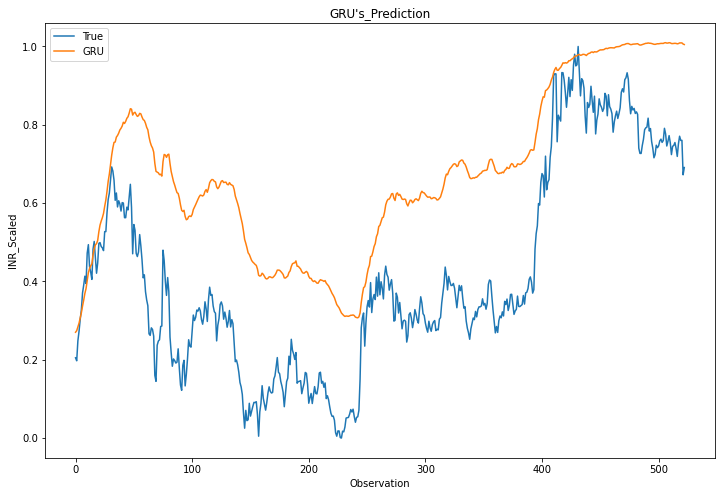

In [54]:
plt.figure(figsize=(12,8))
plt.plot(Y_test, label='True')
plt.plot(y_pred_test_gru, label='GRU')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()